# Exemple 3 : determining the best sowing date for one year - Senegal millet 2013-2023

The purpose of this notebook is to show how SARRA-Py can be used to determine the best yielding sowing date for a period of years. To proceed, we will launch for each year multiple simulations with varying sowing dates, after which we will look at the sowing date leading to the highest simulated yield. We keep the best yielding sowing date for each year, and finally compute statistics across the 2013-2023 period.

This search is obviously heavily dependant on the retained crop parameters used for the simulation. Here, we will use some default parameters for millet, calibrated during previous experiments in the Sahelian zone. 


## Imports

In [1]:
import numpy as np
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import xarray as xr
from sarra_py import *
import geopandas as gpd
from joblib import Parallel, delayed
from contextlib import redirect_stdout, redirect_stderr

## 2. Preparing climate and rainfall data

For this example, we provide rainfall and climate data for Senegal in 2013-2023, sourced from TAMSAT v3.1 for rainfall, and AgERA5 for climate ; the following cell will download it and unzip it. 

- climate data includes daily min, max, mean temperatures (°C), solar irradiance (W/m2), and reference evapotranspiration (mm), sourced from AgERA5
- rainfall data includes... rainfall data (mm), sourced from TAMSAT v3.1



In [ ]:
import os
import urllib.request
import zipfile

# create a folder to store the data
os.makedirs('../data/exemple_data/exemple_3/', exist_ok=True)

# download preformatted data from Zenodo repository
url = 'https://zenodo.org/records/14621757/files/exemple_data_Senegal_2013_2023.zip?download=1'
local_filename = '../data/exemple_data/exemple_3/exemple_data_Senegal_2013_2023.zip' # store the downloaded file in the ../data/exemple_data/ folder
urllib.request.urlretrieve(url, local_filename)
print("File downloaded using urllib.")

# unzip data
path_to_zip_file = "../data/exemple_data/exemple_3/exemple_data_Senegal_2013_2023.zip"
directory_to_extract_to = "../data/exemple_data/exemple_3/" # unzips the file in the same folder

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
print("File unzipped.")

In [3]:
# we set the paths to the data
rainfall_data_path = "../data/exemple_data/exemple_3/TAMSAT_v3.1_senegal_rfe_filled/"
climate_data_path = "../data/exemple_data/exemple_3/AgERA5_senegal/"

## 3. Defining yearly simulation function

Here we define a wrapper function that will perform for a given year all the operations for data loading and launching one simulation per sowing date.

In [4]:
def find_best_sowing_date_year(year, start_sowing_date, sowing_period_duration, interval=5):

    # to be able to parallelize we first define a function that will run the simulation for a given sowing date
    # it is defined inside the main function so that it has access to all the necessary variables
    def run_simulation(init_date, delta):
        
        print("-> estimating yield for sowing day {} (delta = {} days)".format(init_date + datetime.timedelta(days=delta), delta))

        data = base_data.copy() # creating simulation dataset by copying the base_data
        paramITK["DateSemis"] = init_date + datetime.timedelta(days=delta) # setting the sowing date

        # initializing all the necessary variables
        data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)
        data = initialize_default_irrigation(data)
        data = calculate_once_daily_thermal_time(data, paramVariete)

        data = run_model(paramVariete, paramITK, paramTypeSol, data, duration) # running the model
        result = xr.where(data["numPhase"][-1,:,:] != 0, data["rdt"][-1,:,:], np.nan) # extracting the yield, excluding pixels where simulation never started (numPhase = 0)

        del data # free memory
        return result
    
    print("== computing best sowing dates for year {} ==".format(year))

    # hiding all the outputs of this code section
    with open(os.devnull, 'w') as devnull, redirect_stdout(devnull), redirect_stderr(devnull):

        # defining the simulation period (interval in which data is loaded)
        # remember that we want to load data at least one month before the sowing date so that water balance can initialize properly
        date_start = datetime.date(year,4,1) # 01/04/2017
        duration = 220

        grid_width, grid_height = get_grid_size(rainfall_data_path, date_start, duration) # get grid size 
        base_data = xr.Dataset() # initialize empty xarray dataset
        base_data = load_TAMSAT_data(base_data, rainfall_data_path, date_start, duration) # load rainfall data
        base_data = load_AgERA5_data(base_data, climate_data_path, date_start, duration) # load climate data
        base_data = load_iSDA_soil_data(base_data, grid_width, grid_height) # load soil parameters
        base_data = calc_day_length_raster_fast(base_data, date_start, duration) # compute day length raster

        # load variety, cropping system and soil parameters
        file_paramVariete = "millet_variety.yaml"
        file_paramITK = "millet_niger_2017.yaml"
        file_paramTypeSol = "USA_iowa_V42.yaml"
        paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)

    # parallel run the simulations for the different sowing dates
    parallel_jobs = 4 # if you have lots of RAM increase the number of parallel jobs
    results = Parallel(n_jobs=parallel_jobs)(delayed(run_simulation)(start_sowing_date, int(delta)) for delta in np.arange(0, sowing_period_duration, interval)) # parallel run the simulations
    rdt = xr.concat(results, dim="step") # assemble the multi-sowing date yield results in a single xarray dataset

    # find the best sowing date for each pixel with argmax
    # however as argmax is sensitive to NaN values we need to handle them
    all_nan_slices = rdt.isnull().all(dim="step") # identify slices where all values are NaN
    argmax_result = rdt.fillna(np.inf).argmax(dim="step") # compute argmax, ignoring slices with all NaN
    argmax_result = argmax_result.where(~all_nan_slices, np.nan) # Replace indices with NaN where all values were NaN

    return argmax_result

## 4. Run simulations

In [ ]:
# initialize best sowing date array
best_sowing_date = xr.DataArray()

# loop over the years 2013 to 2023 included
for year in range(2013, 2023 + 1):

    # define best date search parameters
    # here we will search for the best sowing date in a 60 days window starting on the 1st of May
    start_sowing_date = datetime.date(year,5,1)
    sowing_period_duration = 60
    interval = 5

    argmax_result = find_best_sowing_date_year(year, start_sowing_date, sowing_period_duration, interval) # run simulations
    
    # store results, taking care of the first iteration
    if best_sowing_date.size == 0:
        best_sowing_date = argmax_result.expand_dims("year")
    else:
        best_sowing_date = xr.concat([best_sowing_date, argmax_result], dim="year")

## 5. Plot results

Now that we have the determined the best sowing date for each year on the period 2013-2023, we can compute temporal agregates to determine the average best sowing date.

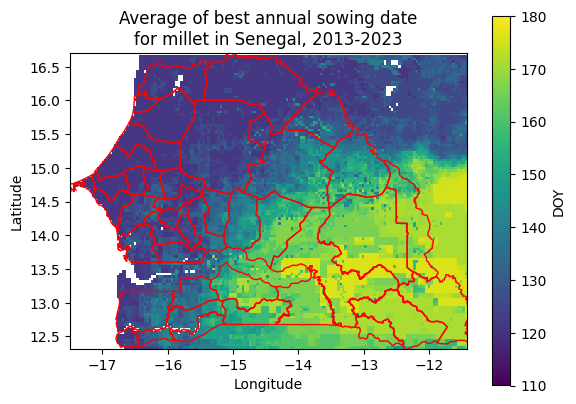

In [42]:
# converting results to DOY
best_sowing_date_DOY = best_sowing_date.mean(dim="year")*interval + start_sowing_date.timetuple().tm_yday 

# plot the results
best_sowing_date_DOY.plot(cbar_kwargs={"label": "DOY"}, vmin=110, vmax=180)
gdf = gpd.read_file("https://geoportal.un.org/arcgis/sharing/rest/content/items/f8bcb307f3ad4f21a43ac8e2c68fa26c/data")
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
plt.title("Average of best annual sowing date\nfor millet in Senegal, 2013-2023")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


We can also compute the variability of the best sowing date, which reveals in some areas the best sowing date is quite stable, whereas in others it can vary up to 20 days from one year to another.

/home/lavarenne/my_venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


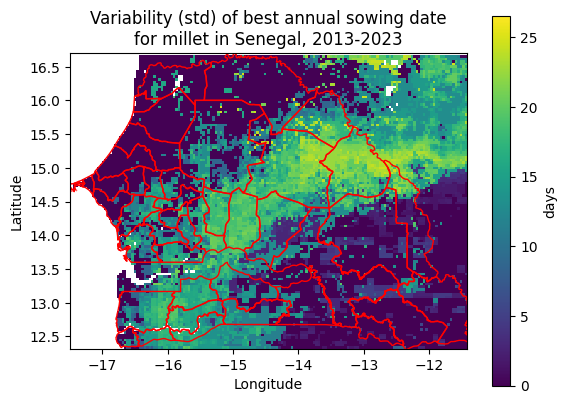

In [39]:
# plot the results for variability
(best_sowing_date*5).std(dim="year").plot(cbar_kwargs={"label": "days"})
gdf = gpd.read_file("https://geoportal.un.org/arcgis/sharing/rest/content/items/f8bcb307f3ad4f21a43ac8e2c68fa26c/data")
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
plt.title("Variability (std) of best annual sowing date\nfor millet in Senegal, 2013-2023")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


Finally, we can subtract one standard deviation from the mean value to determine a map of lower boundary of the best sowing date distribution, which can be interpreted as a "early/safe" best sowing date estimate.

/home/lavarenne/my_venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


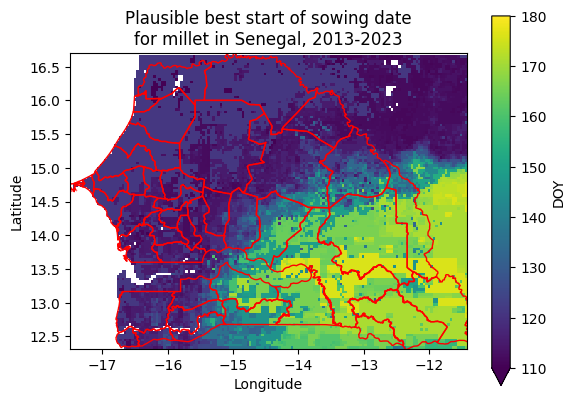

In [43]:
# determine the plausible best start of sowing date (mean - 1 std)
(best_sowing_date_DOY - (best_sowing_date*5).std(dim="year")).plot(cbar_kwargs={"label": "DOY"}, vmin=110, vmax=180)
gdf = gpd.read_file("https://geoportal.un.org/arcgis/sharing/rest/content/items/f8bcb307f3ad4f21a43ac8e2c68fa26c/data")
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
plt.title("Plausible best start of sowing date\nfor millet in Senegal, 2013-2023")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
